In [1]:
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob 


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15545840593016119637
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7921888275194283650
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3204174250714905088
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 41680896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15801985880222555646
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [18]:
ground_truth_adress='/media/immopixel/Amir/server/dataset/tirol/Klein_Dataset2/test/Cropped_CoGT/'
prediction_adress="/media/immopixel/Amir/server/dataset/tirol/Klein_Dataset2/test/New_PIX2PIX/"
#prediction_adress='/media/immopixel/Amir/server/dataset/tirol/Klein_Dataset2/test/Croped_6876_200_orginalPix2Pix_C_overlay_G_Test/'
pred_img_list=glob.glob(prediction_adress+'*.png')
gt_img_list=glob.glob(ground_truth_adress+'*.png')
gt_img_list.sort()
pred_img_list.sort()

In [19]:
import numpy as np

def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    
    '''
    
        n_cl : the number of classes
        t_i : the total number of pixels in class i

        n_ij : the number of pixels of class i predicted to belong to class j. So for class i:
        n_ii : the number of correctly classified pixels (true positives)
        n_ij : the number of pixels wrongly classified (false positives)
        n_ji : the number of pixels wrongly not classifed (false negatives)

    
        (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)

    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)
    print(n_cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)

In [14]:
mean_IoU = []
mean_pixel_acc = []
mean_freq_weighted_IU = []
mean_acc = []

for gt_add,prd_add in zip(gt_img_list,pred_img_list):
    
        gt_image=cv2.imread(gt_add )
        prd_image=cv2.imread(prd_add )

        blur_gt = cv2.GaussianBlur(gt_image, (5, 5), 0)
        (t, label_image) = cv2.threshold(blur_gt, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        blur_pr = cv2.GaussianBlur(prd_image, (5, 5), 0)
        (t, pred_image) = cv2.threshold(blur_pr, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        

        
        pix_acc = pixel_accuracy(pred_image, label_image)
        m_acc = mean_accuracy(pred_image, label_image)
        IoU = mean_IU(pred_image, label_image)
        freq_weighted_IU = frequency_weighted_IU(pred_image, label_image)
        
        mean_pixel_acc.append(pix_acc)
        mean_acc.append(m_acc)
        mean_IoU.append(IoU)
        mean_freq_weighted_IU.append(freq_weighted_IU)



2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [59]:
print("Mean pixel accuracy:", np.mean(mean_pixel_acc))
print("Mean accuraccy:", np.mean(mean_acc))
print("Mean IoU:", np.mean(mean_IoU))
print("Mean frequency weighted IU:", np.mean(mean_freq_weighted_IU))

('Mean pixel accuracy:', 0.93686196970385172)
('Mean accuraccy:', 0.88282679428816835)
('Mean IoU:', 0.82205035370678359)
('Mean frequency weighted IU:', 0.89157518604189323)


('Mean pixel accuracy:', 0.93686196970385172)
('Mean accuraccy:', 0.88282679428816835)
('Mean IoU:', 0.82205035370678359)        mza
('Mean frequency weighted IU:', 0.89157518604189323)


('Mean pixel accuracy:', 0.89442467504693557)
('Mean accuraccy:', 0.73916047278027552)
('Mean IoU:', 0.6501638034247158)
('Mean frequency weighted IU:', 0.82468454034802852)


In [53]:
mean_pixel_acc

[0.9999847412109375,
 0.999969482421875,
 0.9384765625,
 0.9683685302734375,
 0.9506988525390625,
 0.93463134765625,
 0.940185546875,
 0.92388916015625,
 0.8648834228515625,
 0.8986968994140625,
 0.9357757568359375,
 0.9358978271484375,
 0.9356689453125,
 1.0,
 0.9999847412109375,
 0.97784423828125,
 0.9456787109375,
 0.9999847412109375,
 0.9268646240234375,
 0.9752044677734375,
 0.93585205078125,
 0.953155517578125,
 0.8834991455078125,
 0.9805145263671875,
 0.955413818359375,
 0.9722747802734375,
 0.980926513671875,
 0.9999847412109375,
 0.999969482421875,
 1.0,
 0.999969482421875,
 0.9938507080078125,
 0.9347076416015625,
 0.98321533203125,
 0.958984375,
 0.9388885498046875,
 0.9999847412109375,
 0.999969482421875,
 0.9448394775390625,
 0.922332763671875,
 0.9999847412109375,
 0.923370361328125,
 0.9345703125,
 0.9525909423828125,
 0.90704345703125,
 0.9427642822265625,
 0.999969482421875,
 0.954864501953125,
 0.999969482421875,
 0.9746246337890625,
 0.84979248046875,
 0.92774963378

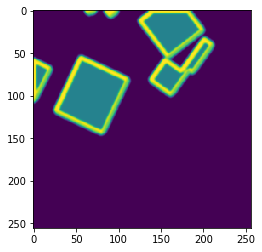

2


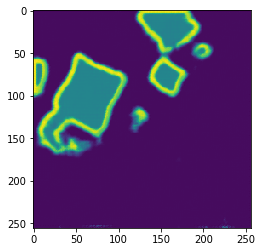

In [57]:

gt_image=cv2.imread(gt_img_list[11],0 )
plt.imshow(gt_image)
plt.pause(2)
prd_image=cv2.imread(pred_img_list[11],0 )
plt.imshow(prd_image)
blur_gt = cv2.GaussianBlur(gt_image, (5, 5), 0)
(t, label_image) = cv2.threshold(blur_gt, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
blur_pr = cv2.GaussianBlur(prd_image, (5, 5), 0)
(t, pred_image) = cv2.threshold(blur_pr, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
pix_acc = pixel_accuracy(pred_image, label_image)
